# Customer Retention by Reducing the Churn

## Problem Statement 
A telecom company has been affected by the increasing number of customers subscribing to the services of a competitor. It is much more expensive to attract new customer than retaining old customer. At the same time, spending too much on or spending on the wrong factor for retaining customer who has no intention to leave (or who was not leaving for that factor which was addressed) could be a waste of money. Therefore it is important to identify the customer who has high probability of leaving and zero down on the reason for it. An analysis of the past records of the customers can give great insights on who might leave and what is the cause. The telecom company already has this data available and data scientist need not collect the data in this case.

In [3]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pylab

import time
from scipy.stats import pearsonr

In [5]:
ch = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
ch.info()
ch.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### The Questions to which we seek answers:

    Are monthly charges different for different contract types?
    Are monthly charges solely dependent on the number/type of the services?
    Are there any discounts given to loyal customers?
    Is there a correlation between monthly charges and churn?
    Is there a correlation between tenure and churn?
    Is there a correlation between certain type of services and churn?
    Is there any person specific trends in churn?
    Can we make predictions on likelihood of a customer churn given the predictor variables listed above
    and, Try quantifying these correlations into actionable items.

    First check what percentage of the given dataset has data for customers who switch and what percentage is loyal?

Overall Customer Churn percentage in the given dataset is 26.54 %


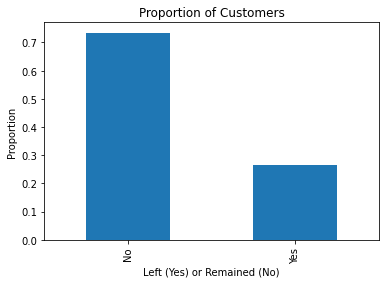

In [6]:
_ = (ch.groupby('Churn')['customerID'].count()/ch['customerID'].count()).plot.bar()
_ = plt.title('Proportion of Customers')
_ = plt.ylabel('Proportion')
_ = plt.xlabel('Left (Yes) or Remained (No)')
print('Overall Customer Churn percentage in the given dataset is {} %'.format(round(ch.Churn.replace({'No':0,'Yes':1}).mean()*100,2)))

## Data Wrangling
    The output of the cell number 2 above gives all the data types and counts of non-null entries. Non-null does not mean valid entries. We need to ensure all of them have meaningful datatypes and valid entries. The TotalCharges is of type object, which means there is some non-numeric entry. It is expected to be float. Look at non-churn and churn group separately, as their dynamics might differ. Compute the I choose to impute the invalid entries with median of each group.

    Senior Citizen is a category variable, however it is given as int. It need not be converted, as it will be eventually converted back to numeric.

In [7]:
# Examine the rows with total charges blank
ch[ch['TotalCharges'] == ' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [8]:
ch[ch['tenure'] == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [9]:
ch.TotalCharges = ch.TotalCharges.apply(lambda x: 0  if x == ' ' else float(x))

In [10]:
# Change No internet service to NoInt for brevity
ch[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']] = ch[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].astype(str).replace({'No internet service': 'NoInt'})
ch['MultipleLines'] = ch['MultipleLines'].replace({'No phone service':'NoPh'})

### Exploratory Data Analysis, Data Story Telling
Now that we have clean data, let us quantify what impact this project could make, if all the customers who go away can be convinced to staying. We will also group tenure into 4 categories for better comprehension.

Total Revenue Lost/Month due to Churn: $ 139130


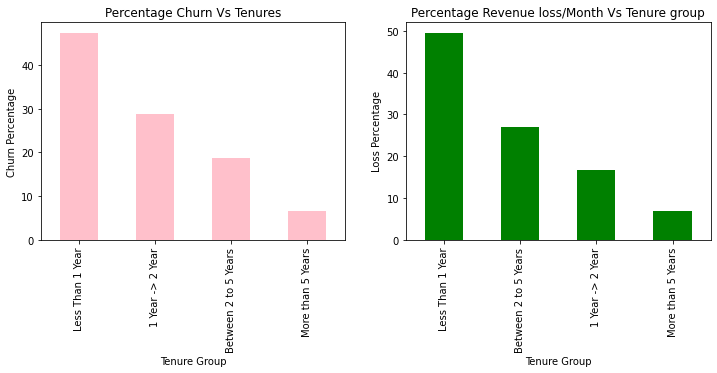

In [11]:
# Split the customers into 4 groups of tenures and see their Churn Rate
_ = plt.figure(figsize=(12,4))
_ = plt.subplot(1,2,1)
ch['Tenure Group'] = 'Between 2 to 5 Years'
ch.loc[ch['tenure'] >59,'Tenure Group'] = 'More than 5 Years' 
ch.loc[ch['tenure'] <= 24,'Tenure Group'] = '1 Year -> 2 Year'
ch.loc[ch['tenure'] <= 12,'Tenure Group'] = 'Less Than 1 Year'
ch['Ch10'] = ch['Churn'].replace({'Yes':1,'No':0})
ch_rate = ch.groupby('Tenure Group')['Ch10'].mean().sort_values(ascending=False)
(round(100*ch_rate,2)).plot.bar(color='pink')

# Evaluate the Revenue Loss per month
ch['revloss'] = ch['MonthlyCharges']*ch['Ch10']
_ = plt.ylabel('Churn Percentage')
_ = plt.title('Percentage Churn Vs Tenures')
_ = plt.subplot(1,2,2)
revenue_group = ch.groupby('Tenure Group')['revloss'].sum().sort_values(ascending=False)
(round(100*revenue_group/revenue_group.sum(),2)).plot.bar(color='g')
_ = plt.ylabel('Loss Percentage')
_ = plt.title('Percentage Revenue loss/Month Vs Tenure group')
print('Total Revenue Lost/Month due to Churn: $',int(revenue_group.sum()))

In [12]:
# Check the stats for numeic types within Churn and No Churn group
numvar = ['tenure','MonthlyCharges','TotalCharges']
round(ch.groupby('Churn')[numvar].describe().T,2)

Churn                      No      Yes
tenure         count  5174.00  1869.00
               mean     37.57    17.98
               std      24.11    19.53
               min       0.00     1.00
               25%      15.00     2.00
               50%      38.00    10.00
               75%      61.00    29.00
               max      72.00    72.00
MonthlyCharges count  5174.00  1869.00
               mean     61.27    74.44
               std      31.09    24.67
               min      18.25    18.85
               25%      25.10    56.15
               50%      64.43    79.65
               75%      88.40    94.20
               max     118.75   118.35
TotalCharges   count  5174.00  1869.00
               mean   2549.91  1531.80
               std    2329.95  1890.82
               min       0.00    18.85
               25%     572.90   134.50
               50%    1679.52   703.55
               75%    4262.85  2331.30
               max    8672.45  8684.80

C:\Users\USER\anaconda3.1\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean Tenure of Two groups
 Churn
No     37.57
Yes    17.98
Name: tenure, dtype: float64


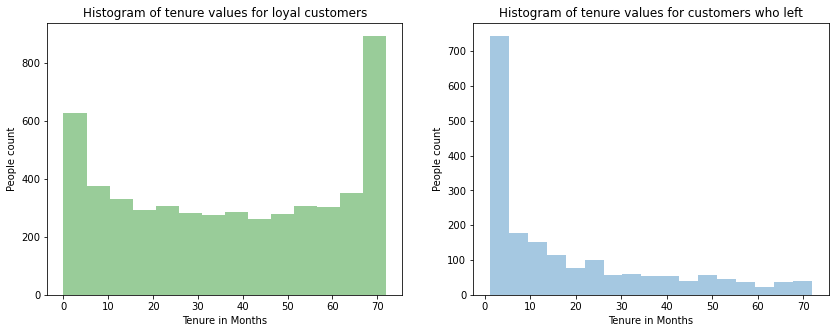

<Figure size 432x288 with 0 Axes>

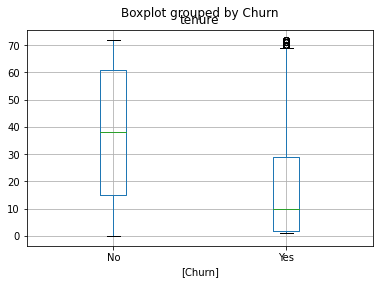

In [13]:
# Plot the histogram of the tenure and see if it tells any story!
fig, ax = plt.subplots(figsize=(14,5))
_ = plt.subplot(1,2,1)
sns.distplot(ch.loc[ch.Churn=='No','tenure'],hist=True,color='g',kde=False)
_ = plt.title('Histogram of tenure values for loyal customers')
_ = plt.xlabel('Tenure in Months')
_ = plt.ylabel('People count')
_ = plt.subplot(1,2,2)
sns.distplot(ch.loc[ch.Churn=='Yes','tenure'],hist=True,kde=False)
_ = plt.title('Histogram of tenure values for customers who left')
_ = plt.xlabel('Tenure in Months')
_ = plt.ylabel('People count')
print("Mean Tenure of Two groups\n",round(ch.groupby('Churn').tenure.mean(),2))
_ = plt.figure()
_ = ch[['Churn','tenure']].boxplot(by='Churn')

In [14]:
# Find the correlation between tenure*Monthly Vs TotalCharges
print("Correlation between Monthly*tenure Vs. Total Charges:",pearsonr(ch.tenure*ch.MonthlyCharges,ch.TotalCharges))

Correlation between Monthly*tenure Vs. Total Charges: (0.9995605537972277, 0.0)


In [15]:
ch['Temp'] = ch.tenure*ch.MonthlyCharges
lm = ols('TotalCharges ~ Temp',ch).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           TotalCharges   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 8.006e+06
Date:                Sat, 11 Dec 2021   Prob (F-statistic):               0.00
Time:                        19:46:09   Log-Likelihood:                -39627.
No. Observations:                7043   AIC:                         7.926e+04
Df Residuals:                    7041   BIC:                         7.927e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9229      1.136     -0.812      0.417      -3.150       1.304
Temp           1.0005      0.000   2829.477      0.000       1.000       1.001
==============================================================================
Omnibus:                      538.795   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3067.278
Skew:                          -0.034   Prob(JB):                         0.00
Kurtosis:                       6.232   Cond. No.                     4.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
ch.drop(['Temp'],axis=1,inplace=True)

Mean Churn Across Contract
Month-to-month    0.427097
One year          0.112695
Two year          0.028319
Name: Ch10, dtype: float64
Mean Churn Across PhoneService
No     0.249267
Yes    0.267096
Name: Ch10, dtype: float64
Mean Churn Across InternetService
DSL            0.189591
Fiber optic    0.418928
No             0.074050
Name: Ch10, dtype: float64


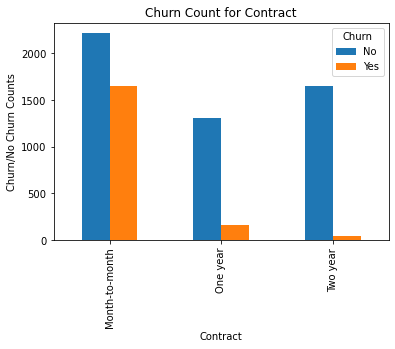

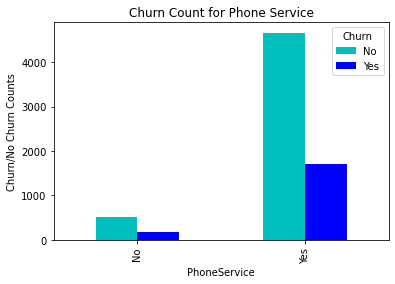

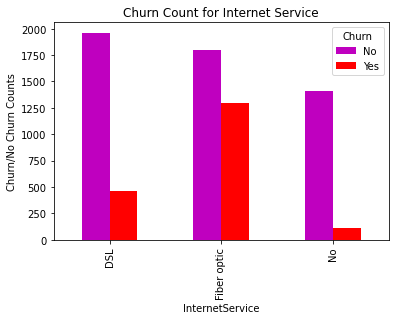

In [17]:
_ = pd.crosstab(ch.Contract,ch.Churn).plot.bar()
_ = plt.title('Churn Count for Contract')
_ = plt.ylabel('Churn/No Churn Counts')
print('Mean Churn Across',ch.groupby('Contract')['Ch10'].mean())
_ = pd.crosstab(ch.PhoneService,ch.Churn).plot.bar(color='cb')
_ = plt.title('Churn Count for Phone Service')
_ = plt.ylabel('Churn/No Churn Counts')
_ = pd.crosstab(ch.InternetService,ch.Churn).plot.bar(color='mr')
_ = plt.title('Churn Count for Internet Service')
_ = plt.ylabel('Churn/No Churn Counts')
print('Mean Churn Across',ch.groupby('PhoneService')['Ch10'].mean())
print('Mean Churn Across',ch.groupby('InternetService')['Ch10'].mean())

In [18]:
# Phone service is redundant.
print("Multiple Lines category counts:\n",ch.MultipleLines.value_counts())
print("Phone Lines category counts:\n",ch.PhoneService.value_counts())

Multiple Lines category counts:
 No      3390
Yes     2971
NoPh     682
Name: MultipleLines, dtype: int64
Phone Lines category counts:
 Yes    6361
No      682
Name: PhoneService, dtype: int64


In [19]:
y = ch.Ch10
X = ch.drop(['customerID','Churn','Ch10','TotalCharges','PhoneService','Tenure Group','revloss'],axis=1,inplace=False).copy()
temp = ch[['tenure','MonthlyCharges','SeniorCitizen']]
X.drop(['tenure','MonthlyCharges','SeniorCitizen'],axis=1,inplace=True)
X = X.apply(lambda x: x.astype('category')).apply(lambda x: x.cat.codes)
X[['tenure','MonthlyCharges','SeniorCitizen']] = temp
X1 = X.copy() # Saving a copy

Percentage Variance by removing TotalCharges: [20.6  13.1   7.74  6.92  5.93  5.89  5.06  4.9   4.56  4.29  4.12  4.06
  3.32  3.26  2.79  2.09  1.38]


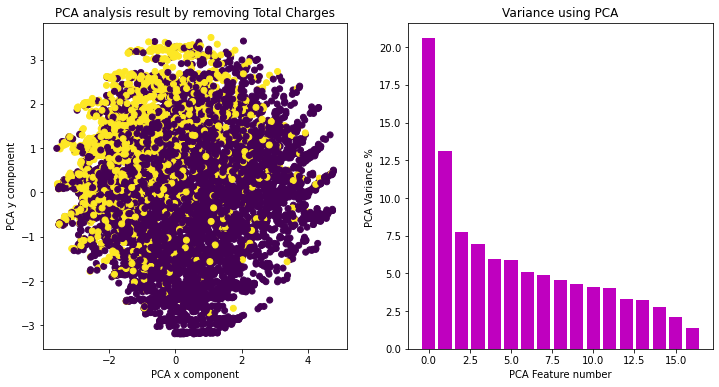

In [20]:
# We will reduce all features to 2D by PCA.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()  # Essential to see the effect of all
X = sc.fit_transform(X)
fig = plt.figure(figsize=(12,6))
pca = PCA()
xx = pca.fit_transform(X)
xs = xx[:,0]
ys = xx[:,1]
fig.add_subplot(1,2,1)
_ = plt.scatter(xs,ys,c=y)
_ = plt.title('PCA analysis result by removing Total Charges')
_ = plt.xlabel("PCA x component")
_ = plt.ylabel("PCA y component")
fig.add_subplot(1,2,2)
_ = plt.bar(np.arange(pca.n_components_),100*np.round(pca.explained_variance_ratio_,4),color='m')
_ = plt.xlabel("PCA Feature number")
_ = plt.ylabel("PCA Variance % ")
_ = plt.title('Variance using PCA')
print("Percentage Variance by removing TotalCharges:",100*np.round(pca.explained_variance_ratio_,4))

The PCA indicates that there are two dominant components which explain all the variance! My guess would be tenure and MonthlyCharges. But Monthly charges may be highly correlated with services, hence we will remove that and try again.

Percentage Variance by tenure and monthly charges: [21.4242 10.924   8.1472  7.3523  6.2567  6.0066  5.337   5.1946  4.8161
  4.532   4.3432  4.2358  3.5212  3.4308  2.9433  1.535 ]


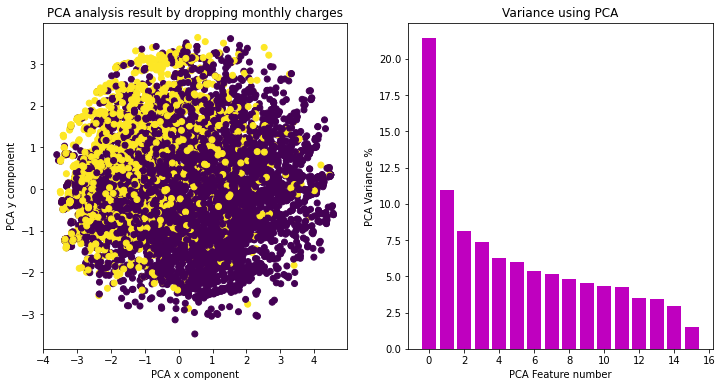

In [21]:
X1.drop(['MonthlyCharges'],axis=1,inplace=True)
fig = plt.figure(figsize=(12,6))
sc = StandardScaler()
X1 = sc.fit_transform(X1)
xx = pca.fit_transform(X1)
xs = xx[:,0]
ys = xx[:,1]
fig.add_subplot(1,2,1)
_ = plt.scatter(xs,ys,c=y)
_ = plt.title('PCA analysis result by dropping monthly charges')
_ = plt.xlabel("PCA x component")
_ = plt.ylabel("PCA y component")
fig.add_subplot(1,2,2)
_ = plt.bar(np.arange(pca.n_components_),100*np.round(pca.explained_variance_ratio_,4),color='m')
_ = plt.xlabel("PCA Feature number")
_ = plt.ylabel("PCA Variance %")
_ = plt.title('Variance using PCA')
print("Percentage Variance by tenure and monthly charges:",100*np.round(pca.explained_variance_ratio_,6))

### K-Means Clustering:
Clustering is done on tenure and Monthly Charges to get intuitive feel for the customer groups behavior. Churn population and non-Churn population are separately clustered into 3 and compared.

Cluster Centers for loyal customers are at:
Month, Dollars, Numbers
[47.46 93.87] 438
[ 8.82 83.58] 949
[ 9.14 38.77] 482
Cluster Centers for loyal customers are at:
Month  Dollars  Numbers
[32.53 24.74] 1789
[59.2  89.46] 1864
[16.99 69.67] 1521


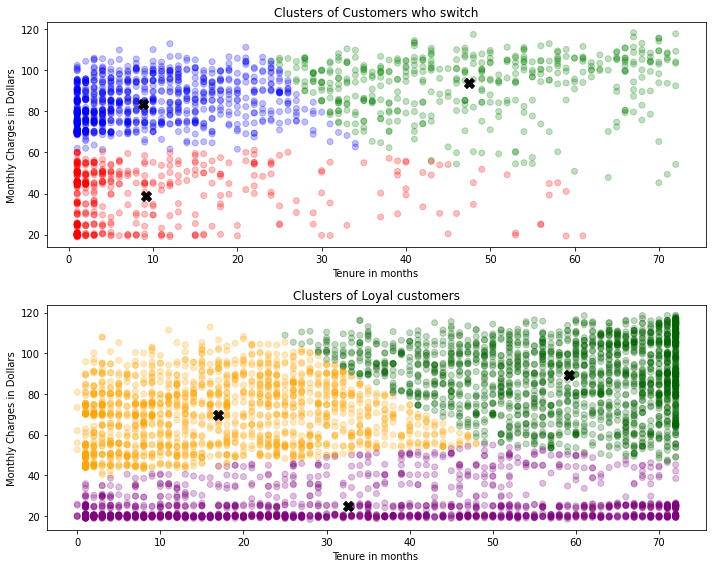

In [22]:
# Import KMeans Model
from sklearn.cluster import KMeans

# Graph and create 3 clusters of Customer Churn
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(ch[ch.Churn=='Yes'][["tenure","MonthlyCharges"]])

kmeans_colors = ['green' if c == 0 else 'blue' if c == 2 else 'red' for c in kmeans.labels_]
fig, ax = plt.subplots(figsize=(10, 8))
plt.subplot(2,1,1) #figsize=(10, 6))
plt.scatter(x="tenure",y="MonthlyCharges", data=ch[ch.Churn=='Yes'],
            alpha=0.25,color = kmeans_colors)
plt.xlabel("Tenure in months ")
plt.ylabel("Monthly Charges in Dollars")
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black",marker="X",s=100)
plt.title("Clusters of Customers who switch")
print("Cluster Centers for loyal customers are at:")
print("Month, Dollars, Numbers")
print(np.round(kmeans.cluster_centers_[0,:],2),(kmeans.labels_==0).sum())
print(np.round(kmeans.cluster_centers_[2,:],2),(kmeans.labels_==2).sum())
print(np.round(kmeans.cluster_centers_[1,:],2),(kmeans.labels_==1).sum())

plt.subplot(2,1,2)

# Graph and create 3 clusters of Customer Churn
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(ch[ch.Churn=='No'][["tenure","MonthlyCharges"]])

kmeans_colors = ['darkgreen' if c == 0 else 'orange' if c == 2 else 'purple' for c in kmeans.labels_]

plt.scatter(x="tenure",y="MonthlyCharges", data=ch[ch.Churn=='No'],
            alpha=0.25,color = kmeans_colors)
plt.xlabel("Tenure in months ")
plt.ylabel("Monthly Charges in Dollars")
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black",marker="X",s=100)
plt.title("Clusters of Loyal customers")
print("Cluster Centers for loyal customers are at:")
print("Month  Dollars  Numbers")
print(np.round(kmeans.cluster_centers_[1,:],2),(kmeans.labels_==1).sum())
print(np.round(kmeans.cluster_centers_[0,:],2),(kmeans.labels_==0).sum())
print(np.round(kmeans.cluster_centers_[2,:],2),(kmeans.labels_==2).sum())
_ = plt.tight_layout()

### Feature Engineering using by one-hot encoding
Creating one hot encoding to suit Linear/Logistic regression is important for the correct interpretation of the features by the model. We do that below, and then drop original columns and the last column of each variable, as it is correlated to the others.

In [23]:
X = ch.drop(['customerID','Churn','Ch10','TotalCharges','PhoneService','Tenure Group','revloss'],axis=1,inplace=False).copy()

In [24]:
cat_vars=['gender','Partner','Dependents','PaperlessBilling','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaymentMethod']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(ch[var], prefix=var)
    X1=X.join(cat_list)
    X=X1
X.drop(cat_vars,axis=1,inplace=True) # Originals need to be dropped

In [25]:
X.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'gender_Female',
       'gender_Male', 'Partner_No', 'Partner_Yes', 'Dependents_No',
       'Dependents_Yes', 'PaperlessBilling_No', 'PaperlessBilling_Yes',
       'MultipleLines_No', 'MultipleLines_NoPh', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_NoInt',
       'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_NoInt',
       'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_NoInt',
       'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_NoInt',
       'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_NoInt',
       'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_NoInt',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic ch

In [26]:
X.drop(['MultipleLines_NoPh','InternetService_No','OnlineSecurity_No','OnlineBackup_No',
        'DeviceProtection_No','TechSupport_No','StreamingTV_No','StreamingMovies_No',        
        'gender_Male','Partner_No','Dependents_No','PaperlessBilling_No',
        'Contract_Month-to-month','PaymentMethod_Credit card (automatic)'],axis=1,inplace=True)
X.drop(['StreamingMovies_NoInt','StreamingTV_NoInt','TechSupport_NoInt','DeviceProtection_NoInt','OnlineBackup_NoInt','OnlineSecurity_NoInt'],axis=1,inplace=True)
XLin = X[[ 'MultipleLines_No', 'MultipleLines_Yes','InternetService_Fiber optic', 'InternetService_DSL',
         'OnlineSecurity_Yes','OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes','StreamingTV_Yes', 'StreamingMovies_Yes']]

R^2 of the fit: 0.999
MSE of the model 1.05


,$ Per month
InternetService_Fiber optic,49.982
InternetService_DSL,25.004
MultipleLines_Yes,24.995
MultipleLines_No,19.978
StreamingTV_Yes,9.967
StreamingMovies_Yes,9.961
TechSupport_Yes,5.031
DeviceProtection_Yes,5.020
OnlineSecurity_Yes,5.016
OnlineBackup_Yes,4.991


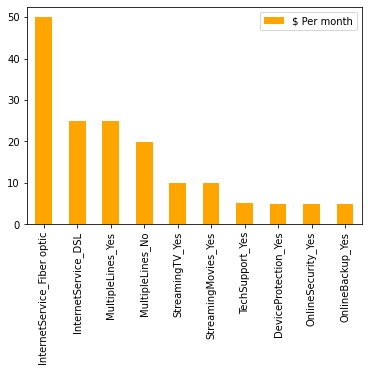

In [27]:
# Fit Linear Regression for Monthly Charges using services
from sklearn.linear_model import LinearRegression
LinReg = LinearRegression(fit_intercept=False)
yLin = ch.MonthlyCharges
LinReg.fit(XLin,yLin)
pred = LinReg.predict(XLin)
print("R^2 of the fit:",np.round(LinReg.score(XLin,yLin),3))
print("MSE of the model {:.2f}".format(np.mean((pred - yLin) ** 2)))
lincoeff = pd.DataFrame(np.round(LinReg.coef_,3),index=XLin.columns,columns=['$ Per month'])
lincoeff.sort_values('$ Per month',ascending=False).plot.bar(color='orange')
lincoeff.sort_values('$ Per month',ascending=False)

C:\Users\USER\anaconda3.1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Percentage of outliers:3.96


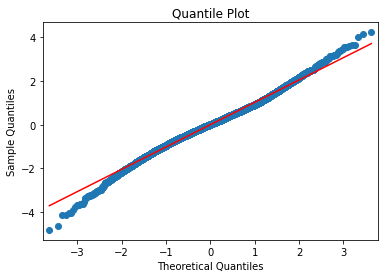

<Figure size 432x288 with 0 Axes>

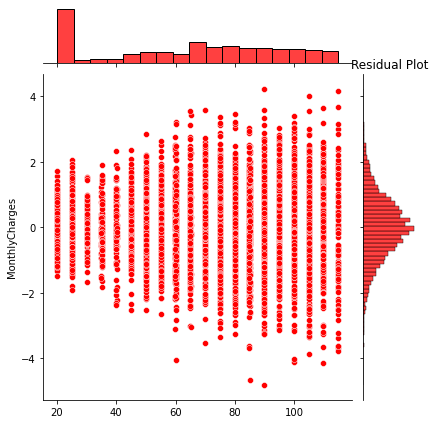

In [28]:
# Checking for verification of normality
resid = pred-yLin
_ = sm.qqplot(resid,line='r')
_ = plt.title('Quantile Plot')
_ = plt.figure()
_ = sns.jointplot(pred,resid,color='r')
_ = plt.title('Residual Plot')
print("Percentage of outliers:{:.2f}".format(100*((abs(resid) > 2.25).sum())*resid.std()/XLin.shape[0]))
#(abs(resid) > resid.std()unt()
#print("Indices of outlier points:",list(np.argsort(abs(pred-ydev)).tail(10)))

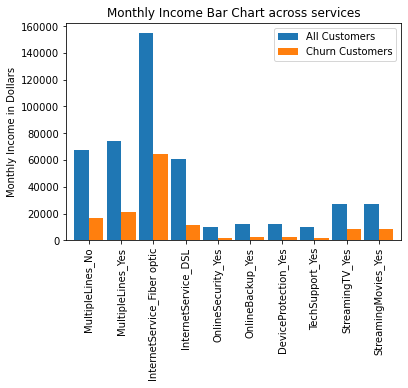

In [29]:
all_cust = round((np.sum(XLin,axis=0)*LinReg.coef_),2)
index1 = y > 0
churn_cust = round((np.sum(XLin.loc[index1,:],axis=0)*LinReg.coef_),2)
joined = pd.concat([all_cust,churn_cust],axis=1)
joined.columns = ['All Customers','Churn Customers']
joined.plot.bar(width = 0.9)
_ = plt.title('Monthly Income Bar Chart across services')
_ = plt.ylabel('Monthly Income in Dollars')

C:\Users\USER\AppData\Local\Temp/ipykernel_4072/1412999049.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(X.corr(), dtype=np.bool)


<AxesSubplot:>

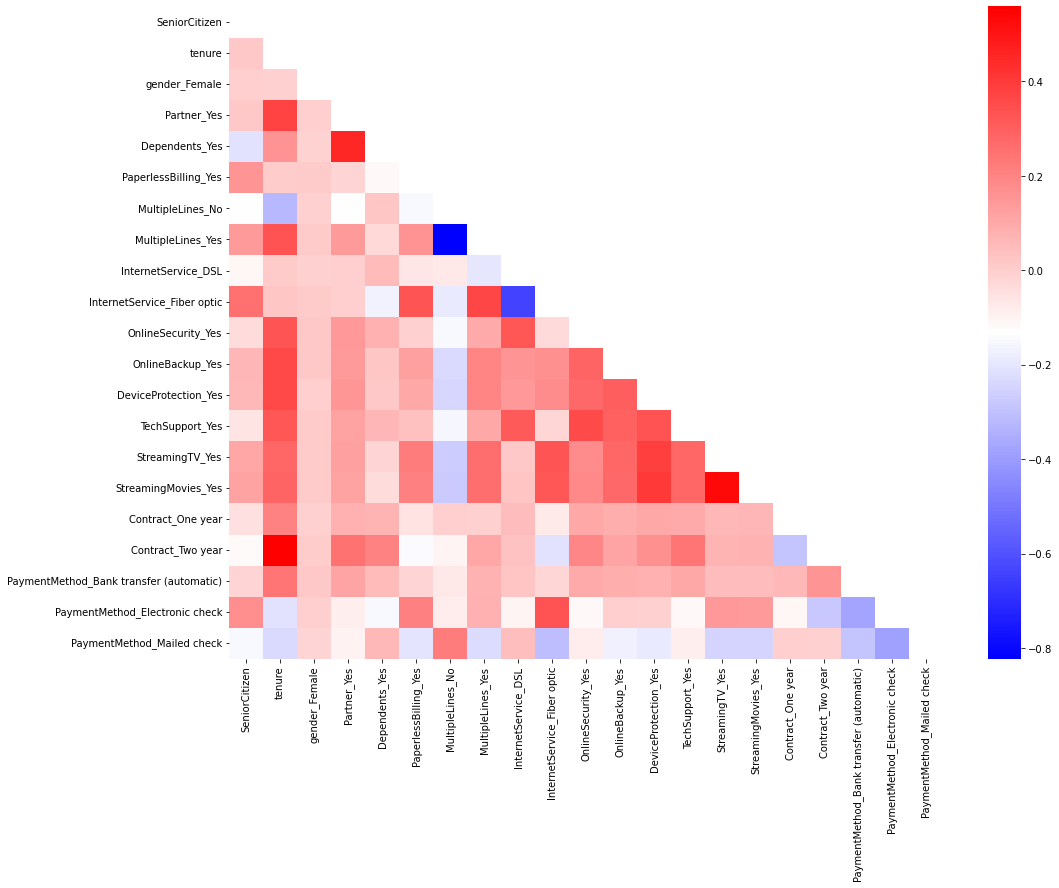

In [30]:
# We need to drop a few dummies to prevent correlations, in nonservice specific ones.
# Plotting correlation for top 10 features
# Ref : https://matplotlib.org/examples/color/colormaps_reference.html for colormap
X.drop('MonthlyCharges',axis=1,inplace=True)
_ = plt.figure(figsize=(16,12))
mask = np.zeros_like(X.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(X.corr(),mask=mask,cmap='bwr')

## Training and Testing Predictive Models

In [31]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [32]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid to search over
# X - usually your training X matrix
# y - usually your training y 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
from sklearn.model_selection import GridSearchCV

def cv_optimize(clf, parameters, X, y, n_jobs=2, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_)
    #print(gs.grid_scores_)
    best = gs.best_estimator_
    return best
#------------------------------------------------------------------------------#
# Function to plot ROC and find area under ROC                                 #
#------------------------------------------------------------------------------#
def find_auc_score(clf,Xin,yin,color='b',name='LogReg',label=1,prob=1) :
    '''Function to plot Receiver characteristics and find AUC'''
    if prob == 1:
        yscore = clf.predict_proba(Xin)
    else :
        yscore = clf.decision_function(Xin)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(yin, yscore[:,label],pos_label=label)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate,color ,label='AUC '+name+' = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.01,1.01])
    plt.ylim([-0.01,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return roc_auc


def pre_process_Xy(Xarray,yarray,test_tr_split_size=0.4) :
    '''Function to split given data into test and (train, dev) set'''
    Xtr,Xdev,ytr,ydev = train_test_split(Xarray,yarray,test_size=test_tr_split_size,random_state=42,stratify=yarray)
    return Xtr,Xdev,ytr,ydev
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def plot_train_test_error(clf,X,y,N=50):
    '''This function plots Train and Test Accuracy for different lengths'''

    training_error = np.empty([N,1])
    dev_error = np.empty([N,1])
    len_tr = int(X.shape[0]/N)
    re_ind = np.random.permutation(X.index)
    X = X.reindex(re_ind)
    y = y.reindex(re_ind)
    for i in range(N) :
        X1 = X[:(i+1)*len_tr]
        y1 = y[:(i+1)*len_tr]
        Xtr,Xte,ytr,yte = train_test_split(X1,y1,test_size=0.5,random_state=42,stratify=y1)
        clf = clf.fit(Xtr, ytr)
        training_error[i,0] = 1 - clf.score(Xtr, ytr)
        dev_error[i,0] = 1 - clf.score(Xte, yte)
    
    plt.plot(np.arange(N)*len_tr,training_error.reshape(np.arange(N).shape),label='train error')
    plt.plot(np.arange(N)*len_tr,dev_error.reshape(np.arange(N).shape),color='m',label='test error')
    plt.title('Train Error and Test Error Vs Number of Samples used (train: test 1:1 ratio)')
    plt.ylabel('Error rate')
    plt.xlabel('Number of samples')
    plt.legend(loc='best')
    return
    
def do_classify(clf, parameters, Xtr,ytr,Xdev,ydev, score_func=None, n_folds=5, n_jobs=2,model_name='LogReg',label=1,prob_dec=1):

    if parameters:
        clf = cv_optimize(clf, parameters, Xtr, ytr, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtr, ytr)
    training_accuracy = clf.score(Xtr, ytr)
    test_accuracy = clf.score(Xdev, ydev)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (100*training_accuracy)+'%')
    print("Accuracy on test data:     %0.2f" % (100*test_accuracy)+'%')
    print("confusion_matrix on dev data")
    ypred =  clf.predict(Xdev)
    print(confusion_matrix(ydev,ypred))
    print("classification report on dev data")
    print(classification_report(ydev,ypred))
    print("########################################################")
  #  multi_auc_roc(clf,Xdev,ydev,prob=1)
    auc_tr = find_auc_score(clf,Xtr,ytr,color='g',name=model_name+'_tr',label=label,prob=prob_dec) 
    auc_dev = find_auc_score(clf,Xdev,ydev,color='orange',name=model_name+'_dev',label=label,prob=prob_dec) 
    return clf,auc_tr,auc_dev

### Logistc Regression Classifier
There are two numerical variables, and they don't need standardization. Result in terms of performance is found to be same with and without. Hence not doing.

BEST {'C': 1, 'class_weight': 'balanced'} 0.7841468253968253
############# based on standard predict ################
Accuracy on training data: 76.09%
Accuracy on test data:     75.48%
confusion_matrix on dev data
[[1551  519]
 [ 172  576]]
classification report on dev data
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      2070
           1       0.53      0.77      0.63       748

    accuracy                           0.75      2818
   macro avg       0.71      0.76      0.72      2818
weighted avg       0.80      0.75      0.77      2818

########################################################
Wall time: 5.57 s


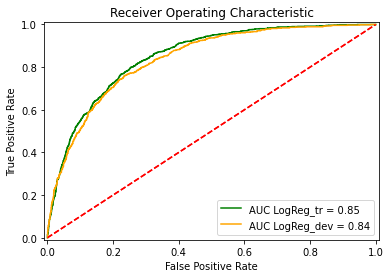

In [33]:
%%time
# Keep a copy to access columns
Xcpy = X.copy()
X['tenure'] = X['tenure'].transform(lambda x: (x - x.mean()) / x.std())
Xtrain, Xdev, ytrain,ydev = train_test_split(X,y,test_size=0.4,stratify=y)
# This is commented because hyperparameter tuning is not done currently.
#Xdev, Xtest, ydev,ytest = train_test_split(Xt,yt,test_size=0.5,random_state=42,stratify=yt)
parameters = {"C": [0.1,1,10,100,10000],"class_weight":['balanced',None]}
logreg,aucrf1,aucrf2 = do_classify(LogisticRegression(), parameters, Xtrain,ytrain,Xdev,ydev, score_func='recall', n_folds=5, n_jobs=2,label=1,prob_dec=1)

,Coeff value
InternetService_Fiber optic,1.821
Contract_Two year,-1.143
tenure,-0.860
InternetService_DSL,0.830
Contract_One year,-0.684
OnlineSecurity_Yes,-0.485
PaymentMethod_Electronic check,0.422
StreamingTV_Yes,0.381
TechSupport_Yes,-0.349
SeniorCitizen,0.345


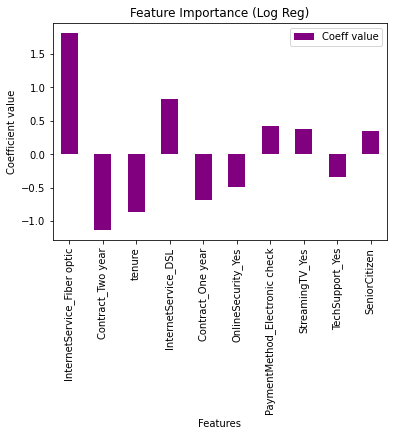

In [34]:
coeff=logreg.coef_
intercept = logreg.intercept_
coeffs_b= logreg.coef_[0,np.argsort(abs(logreg.coef_[0,:]))[::-1]]
names_b = list(Xcpy.columns[np.argsort(abs(logreg.coef_[0,:]))[::-1]])
logfimp = pd.DataFrame(np.round(coeffs_b,3),index=names_b,columns=['Coeff value'])
_ = logfimp.head(10).plot.bar(color='purple')
_ = plt.title('Feature Importance (Log Reg)')
_ = plt.ylabel('Coefficient value')
_ = plt.xlabel('Features')
logfimp

In [41]:
# Trying Feature Selection by limiting to 10
from sklearn.feature_selection import RFE
model = LogisticRegression(class_weight='balanced')
rfe = RFE(model, 10)
rfe = rfe.fit(Xtrain, ytrain)
# After RFE has chosen, now do a prediction using that
print("Chosen Predictors:",Xcpy.columns[rfe.support_])
Xp = Xcpy.loc[:,Xcpy.columns[rfe.support_]]
Xp = sc.fit_transform(Xp)
Xtrain1, Xt, ytrain1,yt = train_test_split(Xp,y,test_size=0.4,stratify=y)
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(Xtrain1,ytrain1)
yp = logreg.predict(Xt)
print("Report:\n",classification_report(yt,yp))
print("Dev Set Accuracy %",np.round(accuracy_score(yt,yp)*100,2))
print("Train set Accuracy %",np.round(accuracy_score(ytrain1,logreg.predict(Xtrain1))*100,2))
yprob = logreg.predict_proba(Xt)
false_positive_rate, true_positive_rate, thresholds = roc_curve(yt, yprob[:,1],pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
_ = plt.title('Receiver Operating Characteristic')
_ = plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
_ = plt.legend(loc='lower right')
_ = plt.plot([0,1],[0,1],'r--')
_ = plt.xlim([-0.01,1.01])
_ = plt.ylim([-0.01,1.01])
_ = plt.ylabel('True Positive Rate')
_ = plt.xlabel('False Positive Rate')

TypeError: __init__() takes 2 positional arguments but 3 were given

In [42]:
# Coefficients with LogReg
Xp = Xcpy.loc[:,Xcpy.columns[rfe.support_]]
coeffs = logreg.coef_[0,np.argsort(abs(logreg.coef_[0,:]))[::-1]]
names = list(Xp.columns[np.argsort(abs(logreg.coef_[0,:]))[::-1]])
print("Coefficients and their values in decreasing importance")
pd.DataFrame(np.round(coeffs,2),index=names,columns=['Coeff value'])

NameError: name 'rfe' is not defined

Threshold Chosen for classification: 0.5
Threshold Tenure:27 months
Max and Min Prob values:0.84 and 0.16
Train Set Accuracy :63.67%
Dev Set Accuracy 64.16%
Report:
               precision    recall  f1-score   support

           0       0.87      0.60      0.71      2070
           1       0.40      0.74      0.52       748

    accuracy                           0.64      2818
   macro avg       0.64      0.67      0.62      2818
weighted avg       0.74      0.64      0.66      2818

Coefficient:-0.037, Intercept:1.0


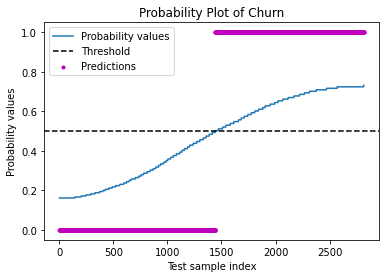

In [43]:
# To evaluate the extent of relation between churn and tenure, trying Logistic with tenure alone.
# Recognizing that tenure and churn are just correlated, it may not be causation
# We could verify if the coefficient with this is close to that obtained by the first 
# logistic regression that includes all variables
logreg_red = LogisticRegression(class_weight='balanced')
Xtrain, Xdev, ytrain,ydev = train_test_split(np.array(ch['tenure']),y,test_size=0.4,random_state=42,stratify=y)
logreg_red.fit(Xtrain.reshape(-1,1),ytrain)
ypred_red = logreg_red.predict_proba(Xdev.reshape(-1,1))
_ = plt.plot(np.sort(ypred_red[:,1]),label = 'Probability values')
ypred = logreg_red.predict(Xdev.reshape(-1,1))
ypred_s = ypred[np.argsort(ypred_red[:,1])]
spred = np.sort(ypred_red[:,1])
vline = spred[ypred_s.argmax()]
print("Threshold Chosen for classification:",round(vline,2))
print("Threshold Tenure:{} months".format(round(0.997/0.037)))
print("Max and Min Prob values:{} and {}".format(round(ypred_red.max(),2),round(ypred_red.min(),2)))
_ = plt.axhline(vline,color='k',linestyle='--',label = 'Threshold')
_ = plt.scatter(np.arange(len(ypred)),ypred_s,color='m',marker='.',label = 'Predictions')
_ = plt.legend(loc='best')
_ = plt.xlabel('Test sample index')
_ = plt.ylabel('Probability values')
_ = plt.title('Probability Plot of Churn')
print("Train Set Accuracy :{:.2f}%".format(100*accuracy_score(ytrain,logreg_red.predict(Xtrain.reshape(-1,1)))))
print("Dev Set Accuracy {:.2f}%".format(100*accuracy_score(ydev,ypred)))
print("Report:\n",classification_report(ydev,ypred))
print("Coefficient:{}, Intercept:{}".format(round(logreg_red.coef_[0,0],3),round(logreg_red.intercept_[0],3)))

In [44]:
X_rf = X = ch.drop(['customerID','Churn','Ch10','TotalCharges','PhoneService','Tenure Group','revloss'],axis=1,inplace=False).copy()
temp = X_rf[['tenure','MonthlyCharges','SeniorCitizen']]
X_rf = X_rf.drop(['tenure','MonthlyCharges','SeniorCitizen'],axis=1)
X_rf = X_rf.apply(lambda x: x.astype('category')).apply(lambda x: x.cat.codes)
X_rf[['tenure','MonthlyCharges','SeniorCitizen']] = temp
Xtrain, Xdev, ytrain,ydev = train_test_split(X_rf,y,test_size=0.4,stratify=y)

## Decision Tree Classifier

BEST {'class_weight': 'balanced', 'max_depth': 6, 'min_samples_leaf': 8} 0.793952380952381
############# based on standard predict ################
Accuracy on training data: 74.93%
Accuracy on test data:     73.24%
confusion_matrix on dev data
[[1446  624]
 [ 130  618]]
classification report on dev data
              precision    recall  f1-score   support

           0       0.92      0.70      0.79      2070
           1       0.50      0.83      0.62       748

    accuracy                           0.73      2818
   macro avg       0.71      0.76      0.71      2818
weighted avg       0.81      0.73      0.75      2818

########################################################
Wall time: 2.95 s


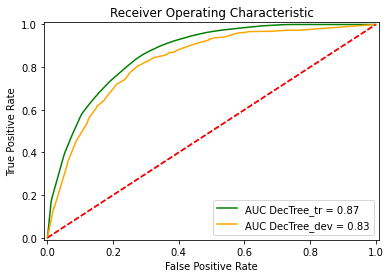

In [45]:
%%time
parameters = {"max_depth": [3,4,6,8,12], 'min_samples_leaf': [1,2,4,8],"class_weight":['balanced',None]}
tr,aucrf1,aucrf2 = do_classify(DecisionTreeClassifier(), parameters, Xtrain,ytrain,Xdev,ydev, score_func='recall', n_folds=5, n_jobs=2,model_name='DecTree',label=1,prob_dec=1)

In [47]:
!pip install graphviz

In [48]:
import graphviz
from sklearn import tree
dot_data = tree.export_graphviz(tr, out_file='dtree.dot', 
                         feature_names=X_rf.columns,  
                         class_names=['N','Y'],  
                         filled=True, rounded=True,  
                         special_characters=True)
#graph = graphviz.Source(dot_data)

## Random Forest Classifier
There is actually no need to drop correlated features for Random Forest. It selects best features at every node of every tree by itself. But from a business perspective, TotalCharges is related to monthly and tenure, we intentionally drop it to get the correct picture (better interpretation) on feature importance. Phone service is also dropped.

BEST {'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 6, 'n_estimators': 10} 0.8082063492063492
############# based on standard predict ################
Accuracy on training data: 73.66%
Accuracy on test data:     72.68%
confusion_matrix on dev data
[[1461  609]
 [ 161  587]]
classification report on dev data
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      2070
           1       0.49      0.78      0.60       748

    accuracy                           0.73      2818
   macro avg       0.70      0.75      0.70      2818
weighted avg       0.79      0.73      0.74      2818

########################################################
Wall time: 1min 54s


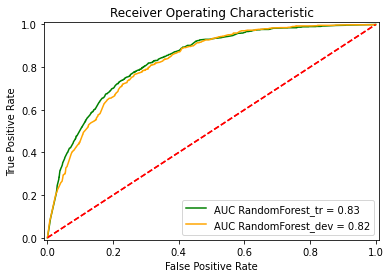

In [49]:
%%time
parameters = {"max_depth": [3,4,6,8,12,None], 'min_samples_leaf': [1,2,4,6],"n_estimators":[10,50,100,200],"class_weight":['balanced',None]}
rf,aucrf1,aucrf2 = do_classify(RandomForestClassifier(), parameters, Xtrain,ytrain,Xdev,ydev, score_func='recall', n_folds=5, n_jobs=2,model_name='RandomForest',label=1,prob_dec=1)

,Feature importance
Contract,0.286964
OnlineSecurity,0.226959
tenure,0.191390
TechSupport,0.113660
OnlineBackup,0.085342
MonthlyCharges,0.062327
InternetService,0.007856
MultipleLines,0.006253
PaperlessBilling,0.005567
PaymentMethod,0.005247


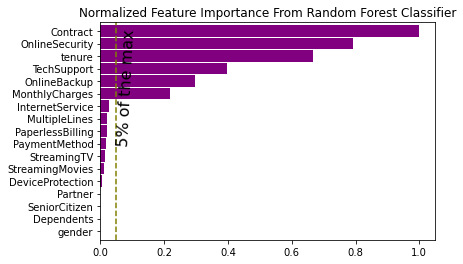

In [50]:
feature_labels = np.array(list(X_rf.columns))
(pd.Series(rf.feature_importances_,index=feature_labels).sort_values(ascending=True)/np.max(rf.feature_importances_)).plot.barh(color='purple',width=0.9)
_ = plt.title('Normalized Feature Importance From Random Forest Classifier')
_ = plt.axvline(0.05,linestyle='--',color='olive')
_ = plt.text(0.05,7,'5% of the max',rotation=87,fontsize=16)
pd.DataFrame(rf.feature_importances_,index=feature_labels,columns=['Feature importance']).sort_values('Feature importance',ascending=False)

In [51]:
# Predictive Model to use
# Assumes clean csv file
def cust_churn_prob_finder(coeff,intercept,csvfile):
    df = pd.read_csv(csvfile,usecols=range(20))
    df_monthly = df.MonthlyCharges
    df.drop(['TotalCharges','customerID','PhoneService','MonthlyCharges'],axis=1,inplace=True)
    cat_vars=['gender','Partner','Dependents','PaperlessBilling','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaymentMethod']
    for var in cat_vars:
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(ch[var], prefix=var)
        X1=df.join(cat_list)
        df=X1
    df.drop(cat_vars,axis=1,inplace=True) # Originals need to be dropped
    df.drop(['MultipleLines_NoPh','InternetService_No','OnlineSecurity_No','OnlineBackup_No',
        'DeviceProtection_No','TechSupport_No','StreamingTV_No','StreamingMovies_No',        
        'gender_Male','Partner_No','Dependents_No','PaperlessBilling_No',
        'Contract_Month-to-month','PaymentMethod_Credit card (automatic)'],axis=1,inplace=True)
    df.drop(['StreamingMovies_NoInt','StreamingTV_NoInt','TechSupport_NoInt','DeviceProtection_NoInt','OnlineBackup_NoInt','OnlineSecurity_NoInt'],axis=1,inplace=True)
    df['tenure'] = df['tenure'].transform(lambda x: (x- x.mean())/x.std())
    prob_test = 1/ (1+ np.exp(-np.dot(np.array(df),coeff[0,:])-intercept))
    df['churn_prob'] = prob_test 
    df['charge*prob'] = df_monthly* prob_test 
    return df

In [53]:
df = cust_churn_prob_finder(coeff,intercept,'WA_Fn-UseC_-Telco-Customer-Churn.csv')
print("Report",classification_report(y,(df['churn_prob'] >= 0.5)))
print("Confusions\n",confusion_matrix(y,(df['churn_prob'] >= 0.5)))

Report               precision    recall  f1-score   support

           0       0.91      0.75      0.82      5174
           1       0.53      0.78      0.63      1869

    accuracy                           0.76      7043
   macro avg       0.72      0.77      0.73      7043
weighted avg       0.81      0.76      0.77      7043

Confusions
 [[3876 1298]
 [ 403 1466]]


In [54]:
df_churn = df[df['churn_prob'] >= 0.5]
index1 = df_churn.sort_values('charge*prob',ascending=False).index
temp = y*(df['churn_prob'] >= 0.5)
index2 = ch.loc[(temp > 0),'MonthlyCharges'].index
print("Potential revenue savings:${}".format(round(ch.loc[index2,'MonthlyCharges'].head(1485).sum())))

Potential revenue savings:$114434
